In [1]:
from qiskit import *

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
IBMQ.save_account('abf9645abd7dc79d9ba56427544fe3ade133308d363774f8b10405ba5de95dd28149a240557b4f3c7ac5ae09746a4078984f8af5eebf483fe32ff6531ce24406', overwrite=True)

In [3]:
qcirc = QuantumCircuit(3, 3)

qcirc.x(0)
qcirc.barrier()

qcirc.h(1)
qcirc.cx(1, 2)
qcirc.barrier()

qcirc.cx(0, 1)
qcirc.h(0)

qcirc.measure([0, 1], [0, 1])
qcirc.barrier()

qcirc.cx(1, 2)
qcirc.cz(0, 2)

qcirc.measure([2], [2])

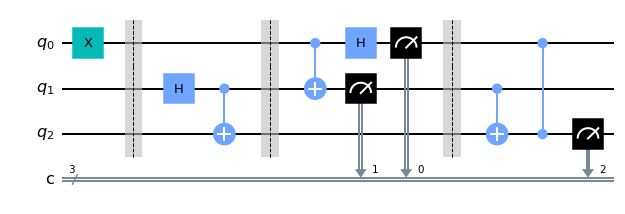

In [4]:
%matplotlib inline
qcirc.draw(output='mpl')

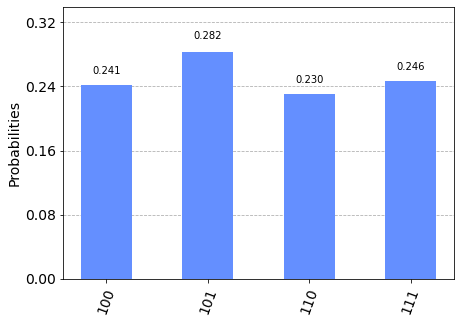

In [5]:
sim = Aer.get_backend('qasm_simulator')
outcome = execute(qcirc, backend=sim, shots=1024).result()
from qiskit.visualization import plot_histogram
plot_histogram(outcome.get_counts(qcirc))

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/matplotlib.py:278: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  self._get_layer_widths()


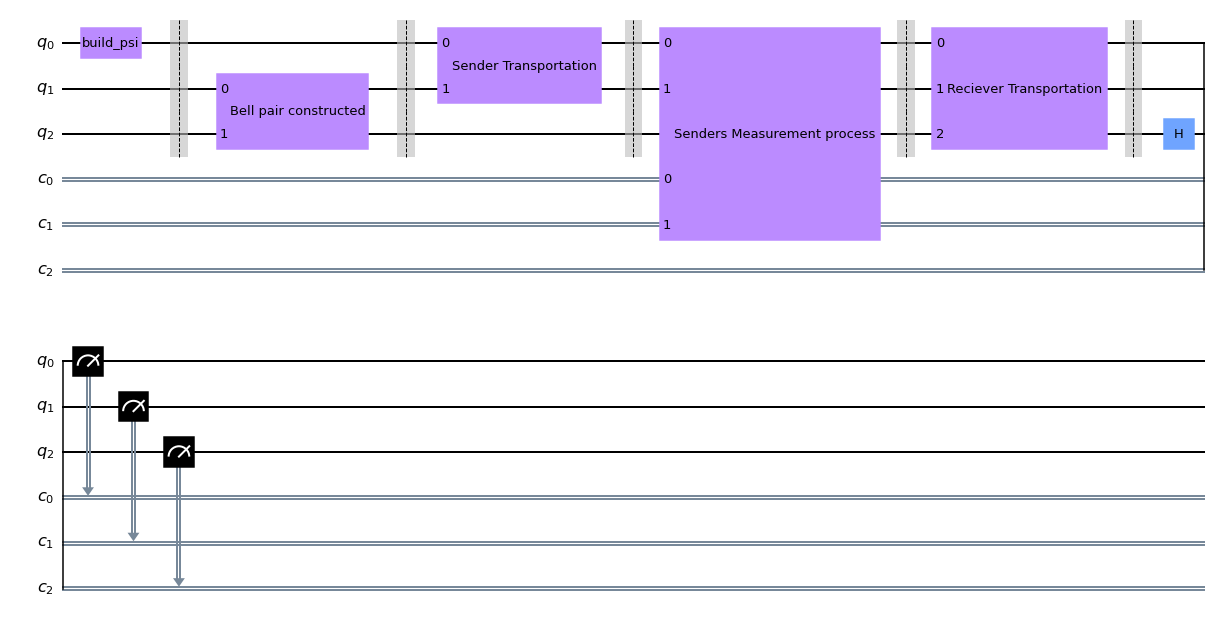

In [6]:
def build_psi(angle):
    qcirc = QuantumCircuit(1, name='build_psi')
    qcirc.h(0)
    qcirc.rz(angle, 0)
    return qcirc

def Bell_pair():
    qcircBell = QuantumCircuit(2, name='Bell pair constructed')
    qcircBell.h(0)
    qcircBell.cx(0,1)
    return qcircBell

def SendersTeleportation():
    senderqcirc = QuantumCircuit(2, name='Sender Transportation')
    senderqcirc.cx(0,1)
    senderqcirc.h(0)
    return senderqcirc

def senderMeasurement():
    senderqcirc = QuantumCircuit(2, 2, name='Senders Measurement process')
    senderqcirc.measure([0,1], [0,1])
    return senderqcirc

def RecieversTeleportation():
    recieverqcirc = QuantumCircuit(3, name='Reciever Transportation')
    recieverqcirc.cx(1,2)
    recieverqcirc.cz(0,2)
    return recieverqcirc

def build_circuit(angle):
    qcirc = QuantumCircuit(3, 3)
    qcirc.append(build_psi(angle).to_instruction(), [0])
    qcirc.barrier()
   
    qcirc.append(Bell_pair().to_instruction(), [1,2])
    qcirc.barrier()
   
    qcirc.append(SendersTeleportation().to_instruction(), [0,1])
    qcirc.barrier()
    
    qcirc.append(senderMeasurement().to_instruction(), [0,1], [0,1])
    qcirc.barrier()
    
    qcirc.append(RecieversTeleportation().to_instruction(), [0,1,2])
    qcirc.barrier()
    
    qcirc.h(2) 
    qcirc.measure([0,1,2], [0,1,2])
    return qcirc

qcirc = build_circuit(0.01)
qcirc.draw(output='mpl')

In [7]:
simulator = Aer.get_backend('qasm_simulator')
outcome = execute(qcirc, backend=simulator, shots=1024).result()
counts = outcome.get_counts(qcirc)
print(counts)
num_c2_zero = sum(counts[c2c1c0] for c2c1c0 in counts if c2c1c0[0] == '0')



{'011': 271, '001': 231, '010': 269, '000': 253}


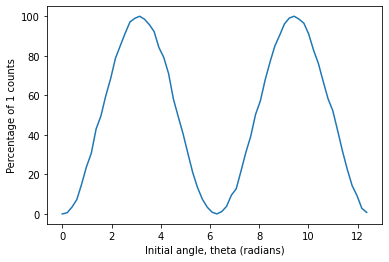

In [8]:
import numpy as np
angles = np.arange(0, 4*np.pi, np.pi/16)

sim = Aer.get_backend('qasm_simulator')

percent_ones = []

for angle in angles:
    qcirc = build_circuit(angle)
    outcome = execute(qcirc, backend=simulator, shots=1024).result()
    counts = outcome.get_counts(qcirc)
    num_c2_ones = sum(counts[c2c1c0] for c2c1c0 in counts if c2c1c0[0] == '1')
    percent_ones.append(num_c2_ones*100./1024)
    
import matplotlib.pyplot as plotter
plotter.plot(angles, percent_ones)
plotter.xlabel('Initial angle, theta (radians)')
plotter.ylabel('Percentage of 1 counts')
plotter.show()

In [9]:
angles = np.arange(0, 4*np.pi, np.pi/16)

qcircs = []
for angle in angles:
    qcirc = build_circuit(angle)
    qcircs.append(qcirc)

In [10]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
qcomp = provider.get_backend('ibmq_santiago')

# run the job on the backend qcomp
job = execute(qcircs, backend=qcomp, shots=512)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

6236d8bbab9307e678381a7d
Job Status: job has successfully run


In [11]:
simresult = execute(qcircs, backend=simulator, shots=512).result()

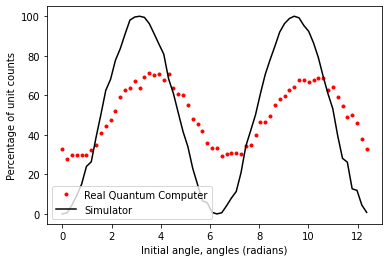

In [12]:
result = job.result()

percent_ones = []
for qcirc in qcircs:
    thiscircuit_counts = result.get_counts(qcirc)
    num_c2_ones = sum(thiscircuit_counts[c2c1c0] for c2c1c0 in thiscircuit_counts if c2c1c0[0] == '1')
    percent_ones.append(num_c2_ones*100./512)
    
percent_ones_sim = []
for qcirc in qcircs:
    thiscircuit_counts = simresult.get_counts(qcirc)
    num_c2_ones = sum(thiscircuit_counts[c2c1c0] for c2c1c0 in thiscircuit_counts if c2c1c0[0] == '1')
    percent_ones_sim.append(num_c2_ones*100./512)
    

plotter.plot(angles, percent_ones, 'r.', label='Real Quantum Computer')
plotter.plot(angles, percent_ones_sim, 'k', label='Simulator')
plotter.xlabel('Initial angle, angles (radians)')
plotter.ylabel('Percentage of unit counts')
plotter.legend()
plotter.show()